# Laboratorio Integrador #1

En el siguiente laboratorio los estudiantes deben trabajar con un dataset de **alta numerosidad-baja dimensionalidad** y aplicar las técnicas de reducción de dimensionalidad estudiadas en clases, así como la integración de las mismas dentro de un sistema de detección de anomalías. Además, se recomienda que los estudiantes validen los espacios reducidos en un flujo de clasifación supervisada para contrastar resultados.

Objetivo:
*   Implementar un sistema de detección de anomalías sobre el espacio original de los datos, un espacio reducido con técnicas no lineales (Isomap) y no geométricas (ICA).
*   Analizar los resultados de clasificación obtenidos en distintos ecenarios usando algoritmos clásicos (Isolation Forest, Local Outlier Factor, one-class SVM) para la detección de anomalías.

Actividad Evaluativa:
1.   Es un trabajo individual.
2.   Implementar las dos técnicas de reducción de dimensionalidad (Isomap e ICA) al dataset de trabajo y obtener dos espacios reducidos. Sugerentemente variar los parámetros de los modelos de reducción de dimensionalidad para alcanzar el mejor desempeño (ej: n_components = 7,17,27,30; neighbors=5,10). Mostrar los gráficos de los espacios reducidos para cada combinación de parámetros (Un subplot tipo grid)
3.   Aplicar en el espacio original y los reducidos, al menos uno de los algoritmos de detección de anomalías proporcionados y medir el desempeño de clasificación usando dos métricas supervisadas (Precision, Recall). Construir el plot PR (precission-recall) para cada resultado de clasficación del algoritmo seleccionado.
4.   Presentar un análisis de resultados de acuerdo a las métricas calculadas y el plot PR (precision-recall) donde se evidencie la comparativa y la selección del esquema ganador (modelo de reducción + clasificador) durante el entrenamiento.
5.   Aplicar el esquema seleccionado como ganador (del punto 4) al conjunto test externo y calcular las métricas precision y recall para constatar el poder de generalización.
6.   Subir el cuaderno desarrollado a la carpeta de trabajo en el D2L.

**Nota:** El conjunto test no puede tener más del 90% de las instancias.  

Valor:
*   25 puntos

Penalizaciones:
*   Cualquier error de implementación o concepto, se penalizará con -1 punto (acumulativo).
*   La no realización del punto 2 de la actividad se penalizará con el 50% (10 puntos).
*   La no realización del punto 3 de la actividad se penalizará con el 20% (4 puntos).
*   La no realización del punto 4 de la actividad se penalizará con el 20% (4 puntos).
*   La no realización del punto 5 de la actividad se penalizará con el 10% (2 puntos).
*   La no realización del punto 6 de la actividad se penalizará con el 100% (25 puntos).



# *Setup*
Overall libraries for data handling, visualization, preparation, and evaluation

In [1]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time
import io
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Load and Explore data

In [2]:
# Load datasets
file_path = 'credit_card.csv'
data = pd.read_csv(file_path)
# Preview data
data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Describe data
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
# Count total fraud
print("Number of fraudulent transactions:", data['Class'].sum())

Number of fraudulent transactions: 492


In [5]:
# Split to train and test and scale features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
porcent= 0.1 ## Pórcentakje a usar 
### Divido los No Fraude y Fraude
data_NoFraud = data[data['Class'] == 0] ## No Fraud transactions
data_Fraud = data[data['Class'] == 1] ## Fraud transactions
## Concateno los datos de NoFraud y Fraude, tomando un porcentaje de NoFraud
new_data= pd.concat([data_NoFraud.sample(n=int(len(data_NoFraud)*porcent), random_state=42), data_Fraud], axis=0)
print("New dataset shape:", new_data.shape)
# Divido en trian y test, manteniendo la proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    new_data.drop('Class', axis=1), 
    new_data['Class'], 
    test_size=0.3, 
    random_state=42, 
    stratify=new_data['Class']
)

print("Frauds in training set:", y_train.sum())
print("Frauds in test set:", y_test.sum())

# Normalizo la Data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
#X_train_std=X_train.copy()




New dataset shape: (28923, 31)
Frauds in training set: 344
Frauds in test set: 148


# MLC



In [6]:
#from sklearn.ensemble import IsolationForest
#
## Parámetros del Isolation Forest
#n_estimators = 100
#contamination = 0.2  # Ajusta esto según la proporción de anomalías esperadas
#random_state = 42
#
## Inicializar Isolation Forest
#iso_forest = IsolationForest(n_estimators=n_estimators, 
#                             contamination=contamination, 
#                             random_state=random_state)
#
## Ajustar el modelo a los datos de entrenamiento
#iso_forest.fit(data)
#
## Predecir anomalías (1 para normal, -1 para outliers)
#y_pred_train = iso_forest.predict(data)


In [7]:
#from sklearn.neighbors import LocalOutlierFactor
#
## Parámetros del Local Outlier Factor
#n_neighbors = 20  # Número de vecinos a considerar, ajusta según sea necesario
#contamination = 0.2  # Proporción esperada de anomalías
#
## Inicializar y predecir con Local Outlier Factor
#lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
#y_pred_train = lof.fit_predict(data)


In [8]:
#from sklearn.svm import OneClassSVM
#
## Parámetros del One-Class SVM
#nu = 0.02  # Proporción de anomalías esperadas (similar a `contamination`)
#kernel = 'rbf'  # Tipo de kernel, 'rbf' es común para detectar outliers
#gamma = 'scale'  # Ajuste automático del parámetro gamma
#
## Inicializar One-Class SVM
#oc_svm = OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
#
## Ajustar el modelo a los datos de entrenamiento y predecir anomalías
#oc_svm.fit(data)
#y_pred_train = oc_svm.predict(data)


# Punto 2

Implementar las dos técnicas de reducción de dimensionalidad (Isomap e ICA) al dataset de trabajo y obtener dos espacios reducidos. Sugerentemente variar los parámetros de los modelos de reducción de dimensionalidad para alcanzar el mejor desempeño (ej: n_components = 7,17,27,30; neighbors=5,10). Mostrar los gráficos de los espacios reducidos para cada combinación de parámetros (Un subplot tipo grid)




In [9]:
# View scatterplot
def scatterPlot_seaborn(xDF, yDF, algoName, ax):
    # Tomar las dos primeras columnas para graficar
    tempDF = pd.DataFrame(data=xDF.iloc[:, 0:2], index=xDF.index)
    
    # Añadir etiquetas
    tempDF = pd.concat((tempDF, yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]

    # Dibujar usando seaborn.scatterplot en el eje ax
    sns.scatterplot(
        data=tempDF,
        x="First Vector",
        y="Second Vector",
        hue="Label",
        ax=ax,
        palette="Set2",
        alpha=0.7
    )

    # Personalizar
    ax.set_title(f"Separation using {algoName}")
    ax.set_xlabel("First Vector")
    ax.set_ylabel("Second Vector")
    ax.legend(title="Label")
    plt.tight_layout()

## Isomap

In [ ]:
from sklearn.manifold import Isomap
n_components = [7,17,27,30] 
neighbors= [5,10] 
sp_IS=[]
for n in n_components:
    columns=[f"IS{n+1}" for n in range(n)]
    for neighbor in neighbors:
        print("n_components:", n, "neighbors:", neighbor)
        isomap = Isomap(n_components=n, n_neighbors=neighbor,n_jobs=-1)
        X_train_isomap = isomap.fit_transform(X_train_std)
        sp_IS.append(pd.DataFrame(X_train_isomap, columns=columns))

n_components: 7 neighbors: 5


e:\Users\Documents\Maestria\Semana_1_ANS\venv\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
e:\Users\Documents\Maestria\Semana_1_ANS\venv\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
e:\Users\Documents\Maestria\Semana_1_ANS\venv\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
e:\Users\Documents\Maestria\Semana_1_ANS\venv\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and do

n_components: 7 neighbors: 10


NameError: name 'n_components' is not defined

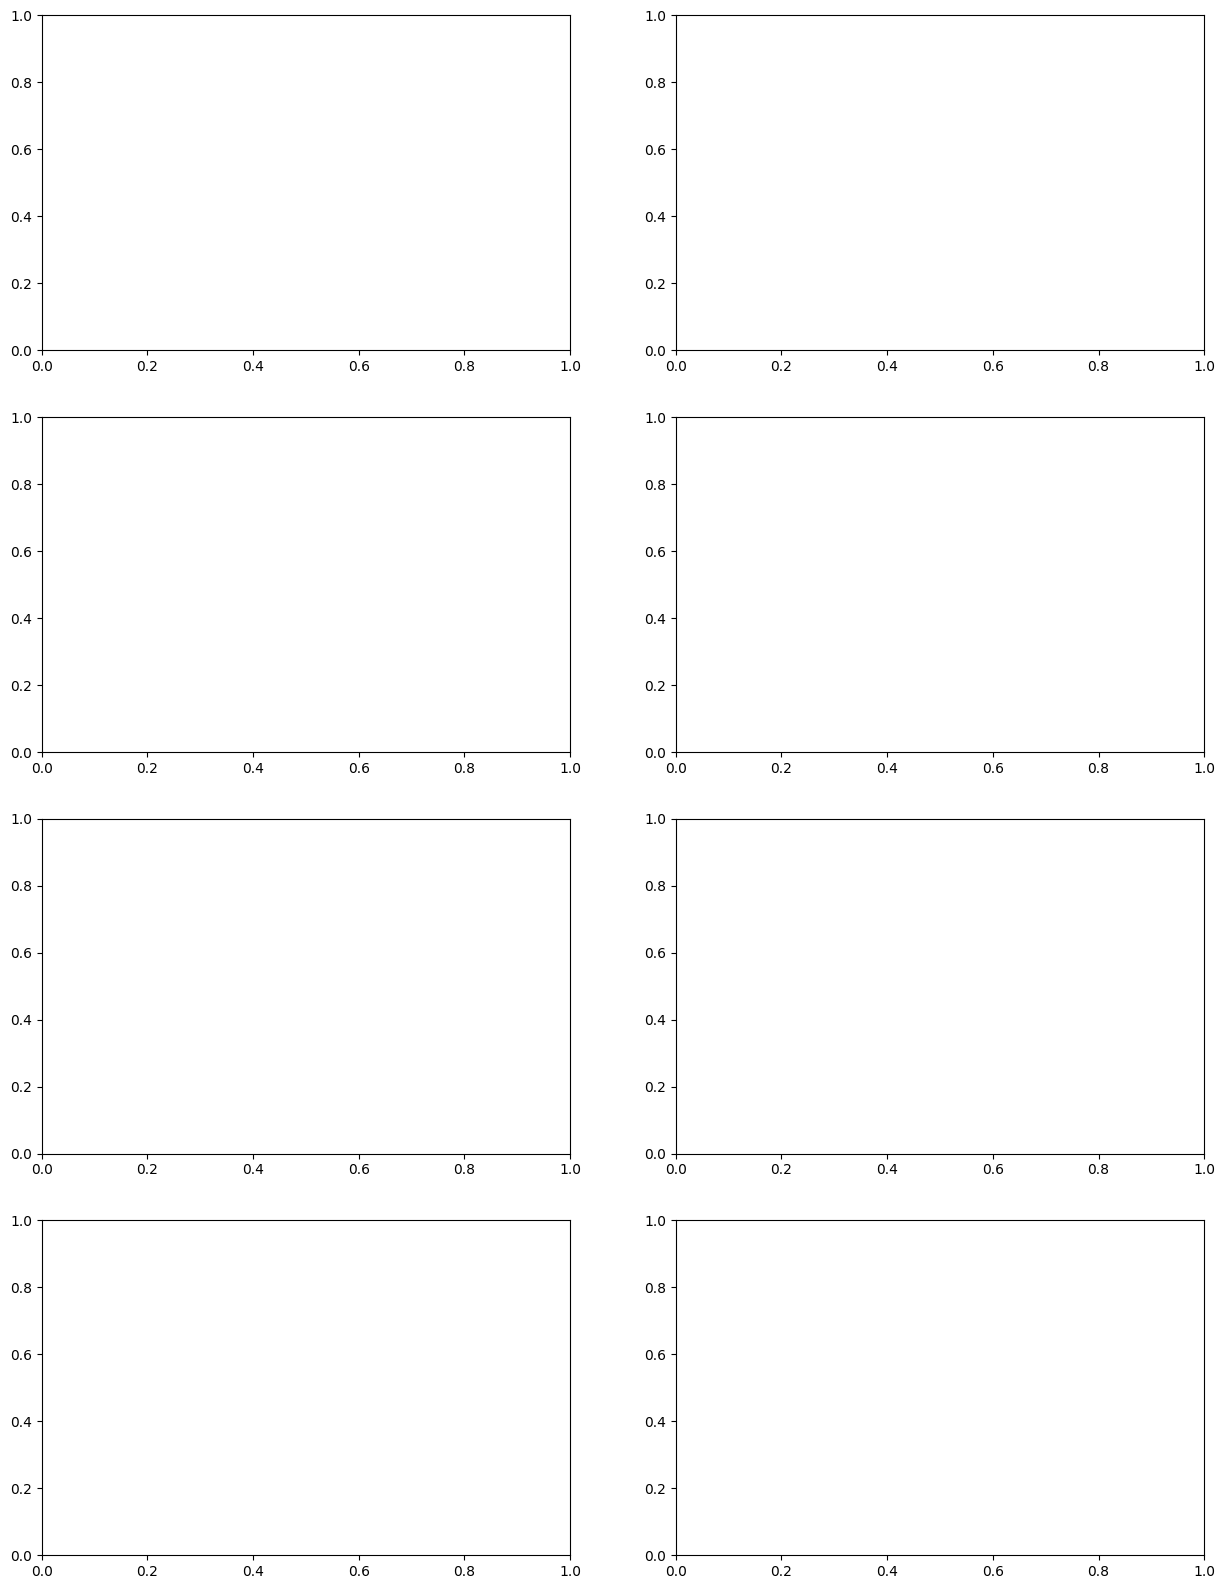

In [ ]:
import matplotlib.pyplot as plt
index = 0
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(15, 20))
ax = ax.flatten()
for n in n_components:
    for neighbor in neighbors:
        scatterPlot_seaborn(sp_IS[index], y_train, f"Isomap n={n}, neighbors={neighbor}", ax[index])
        index += 1

## ICA

In [ ]:
from sklearn.decomposition import FastICA
n_components = [7,17,27,30] 
sp_ICA = []
for n in n_components:
    columns=[f"IS{n+1}" for n in range(n)]
    print("n_components:", n)
    isomap = FastICA(n_components=n, random_state=42, max_iter=1000)
    X_train_isomap = isomap.fit_transform(X_train_std)
    sp_ICA.append(pd.DataFrame(X_train_isomap, columns=columns))

(20246, 27)


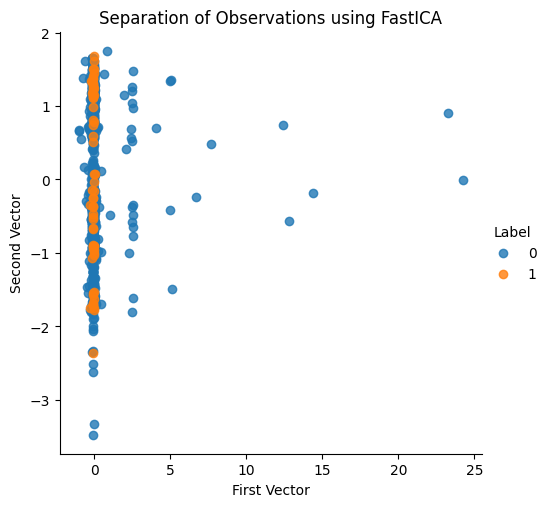

In [ ]:
index = 0
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 20))
ax = ax.flatten()
for n in n_components:
    scatterPlot_seaborn(sp_IS[index], y_train, f"ICA n={n}", ax[index])
    index += 1

# Punto 3
Aplicar en el espacio original y los reducidos, al menos uno de los algoritmos de detección de anomalías proporcionados y medir el desempeño de clasificación usando dos métricas supervisadas (Precision, Recall). Construir el plot PR (precission-recall) para cada resultado de clasficación del algoritmo seleccionado.



In [ ]:
a
def curve_PR_RC(prec, rec, ap, n_components, algo_name):
    plt.figure(figsize=(8, 6))
    plt.plot(rec, prec, label=f"AP={ap:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for Anomaly Detection\n Components: {n_components}, Algorithm: {algo_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

[-2.33124144 -2.52191687 -2.31183637 ... -1.59880439 -1.67209833
 -0.91409528]


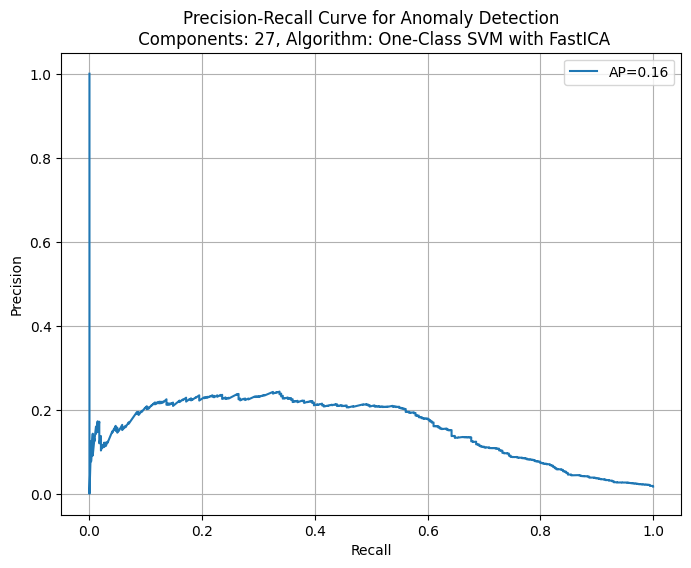

In [ ]:
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    average_precision_score,
)

# Parámetros del One-Class SVM
nu = 0.02  # Proporción de anomalías esperadas (similar a `contamination`)
kernel = "rbf"  # Tipo de kernel, 'rbf' es común para detectar outliers
gamma = "scale"  # Ajuste automático del parámetro gamma

# Inicializar One-Class SVM
oc_svm = OneClassSVM(nu=nu, kernel=kernel, gamma=gamma) 

# Ajustar el modelo a los datos de entrenamiento y predecir anomalías
oc_svm.fit(X_ica)
y_pred_train = -oc_svm.decision_function(X_ica) # usamos negativo para que mayor = más anómalo
print(y_pred_train)
# Curva PR PCA
prec_p, rec_p, _ = precision_recall_curve(y_train, y_pred_train)
ap_p = average_precision_score(y_train, y_pred_train)

# Graficar la curva PR
curve_PR_RC(prec_p, rec_p, ap_p, n_components, "One-Class SVM with FastICA")





# Punto 4


# Punto 5